In [1]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import os

import bin2cell as b2c

#create directory for stardist input/output files
os.makedirs("stardist", exist_ok=True)

VisiumHD has the potential to be the most revolutionary technology in the field since droplet based single cell methods. Seeing how it's a fresh development, ways to maximise the utility of the data need to be proposed. Its 2um resolution is subcellular, and should in principle be useable for recreating cells more accurately than just going for the next resolution up (8um) and treating those as cells.

Bin2cell attempts to handle this problem. It starts by correcting for a novel technical effect in the data in variable bin dimensions, and then proposes a bin to cell assignment based on image segmentation. The result is an object with putative cells in it, ready for downstream analysis. The segmentation can be performed on both the morphology (H&E/IF) image and a visualisation of gene expression data, with certain caveats for both that will be discussed within the notebook.

**The required inputs are the 2um bin output and the `spatial` folder from spaceranger, along with the high resolution morphology image that was used on input (passed via `--image`).** The [10X demo mouse brain data](https://www.10xgenomics.com/datasets/visium-hd-cytassist-gene-expression-libraries-of-mouse-brain-he) has the various binned outputs [here](https://cf.10xgenomics.com/samples/spatial-exp/3.0.0/Visium_HD_Mouse_Brain/Visium_HD_Mouse_Brain_binned_outputs.tar.gz), the high resolution H&E image [here](https://cf.10xgenomics.com/samples/spatial-exp/3.0.0/Visium_HD_Mouse_Brain/Visium_HD_Mouse_Brain_tissue_image.tif), and the spaceranger spatial folder [here](https://cf.10xgenomics.com/samples/spatial-exp/3.0.0/Visium_HD_Mouse_Brain/Visium_HD_Mouse_Brain_spatial.tar.gz). Download all of the above and extract them into the same directory as the notebook before proceeding.

In [2]:
path = "binned_outputs/square_002um/"
#the image you used for --image of spaceranger, that's the one the spatial coordinates are based on
source_image_path = "Visium_HD_Mouse_Brain_tissue_image.tif"
spaceranger_image_path = "spatial"

Loading the count matrix currently requires a bespoke loader function as 10X have moved the spot coordinates into a Parquet file, and started storing their tissue images into a separate `spatial` folder (with symlinks in the binned folders, which may break on transfer). The required syntax changes have been [offered to Scanpy](https://github.com/scverse/scanpy/pull/2992) so hopefully just using Scanpy's default loader will be sufficient soon.

In [3]:
adata = b2c.read_visium(path, 
                        source_image_path = source_image_path, 
                        spaceranger_image_path = spaceranger_image_path
                       )
adata.var_names_make_unique()
adata

anndata.py (1820): Variable names are not unique. To make them unique, call `.var_names_make_unique`.
anndata.py (1820): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 6296688 × 19059
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

Let's slightly filter the object - require the genes to show up in three spots, and require the spots to have any information at all (the data is extremely sparse at this stage).

In [4]:
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_counts=1)
adata

AnnData object with n_obs × n_vars = 6132629 × 18823
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

Over the course of the demo, bin2cell will perform a segmentation of both the H&E image and a gene expression representation of the data. When performing segmentation, the resolution of the input images is controlled via the `mpp` parameter. This stands for microns per pixel and translates to how many micrometers are captured in each pixel of the input. For example, if using the array coordinates (present as `.obs["array_row"]` and `.obs["array_col"]`) as an image, each of the pixels would have 2 micrometers in it, so the `mpp` of that particular representation is 2.

In local testing of the mouse brain, using an `mpp` of 0.5 has worked well with both GEX and H&E segmentation. The StarDist models were trained on images with an mpp closer to 0.3.

Since we're already generating a custom resolution H&E image, `b2c.scaled_he_image()` stores it within the object so it can be used for visualisation. The function crops the image to an area around the actual spatial grid present in the object with a default buffer of 150 pixels, and the new coordinates are captured in `.obsm["spatial_cropped_150_buffer"]`. The new image can be used for plotting by providing `basis="spatial_cropped_150_buffer"` and `img_key="0.5_mpp_150_buffer"` to `sc.pl.spatial()`.

For segmentation purposes, the image needs to be saved to the drive, and the function does so to a user-specified `save_path`. If fiddling with the `mpp` to get the segmentation to cooperate, you can provide `store=False` to reduce the object's footprint - a single custom `mpp` image will probably suffice for plotting purposes.

**If working with an IF rather than H&E image**, bin2cell offers `b2c.scaled_if_image()` which is very similar to `b2c.scaled_he_image()`, but has a mandatory `channel` argument which should point to the index of the DAPI signal in the channel list. This creates a greyscale image, which should be segmented with StarDist's fluorescence model with syntax akin to what is done for the GEX representation later in this notebook.

In [5]:
#likely to be closer to 0.3 for your data
mpp = 0.5

b2c.scaled_he_image(adata, mpp=mpp, save_path="stardist/he.tiff")

Cropped spatial coordinates key: spatial_cropped_150_buffer
Image key: 0.5_mpp_150_buffer


Visium HD suffers from variable bin sizing. When printing the chips, the 2um bins have some variability in their width/height. Inspecting the total counts per spot reveals a characteristic striped appearance, with some rows/columns capturing visibly fewer transcripts than others.

To overcome this, `b2c.destripe()` identifies a user-specified quantile (by default 0.99) of total counts for each row, then divides the counts of the spots in that row by that value. This procedure is then repeated for the columns. `.obs[adjusted_counts_key]` (by default ``"n_counts_adjusted"``) is obtained by multiplying the resulting per-spot factor by the global quantile of count totals, and the count matrix is by default rescaled to match it.

In [6]:
b2c.destripe(adata)

_construct.py (149): Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Prior to the adjustment, the count total has a visible striped appearance. The effect is diminished after the correction.

anndata.py (1209): Trying to modify attribute `.var` of view, initializing view as actual.
anndata.py (1209): Trying to modify attribute `.var` of view, initializing view as actual.


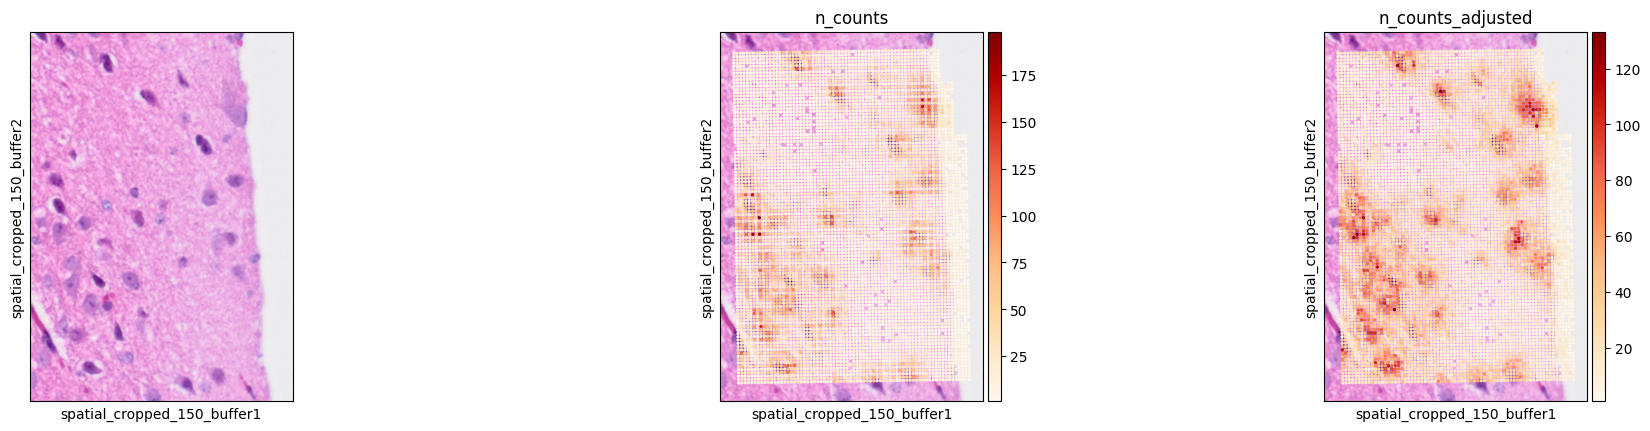

In [7]:
#define a mask to easily pull out this region of the object in the future
mask = ((adata.obs['array_row'] >= 1450) & 
        (adata.obs['array_row'] <= 1550) & 
        (adata.obs['array_col'] >= 250) & 
        (adata.obs['array_col'] <= 450)
       )

bdata = adata[mask]
sc.pl.spatial(bdata, color=[None, "n_counts", "n_counts_adjusted"], color_map="OrRd",
              img_key="0.5_mpp_150_buffer", basis="spatial_cropped_150_buffer")

We can take this opportunity to compare our custom high resolution H&E image versus the default one present in the spaceranger output. The image we made is sharper, which is of particular relevance while working with the 2um bins.

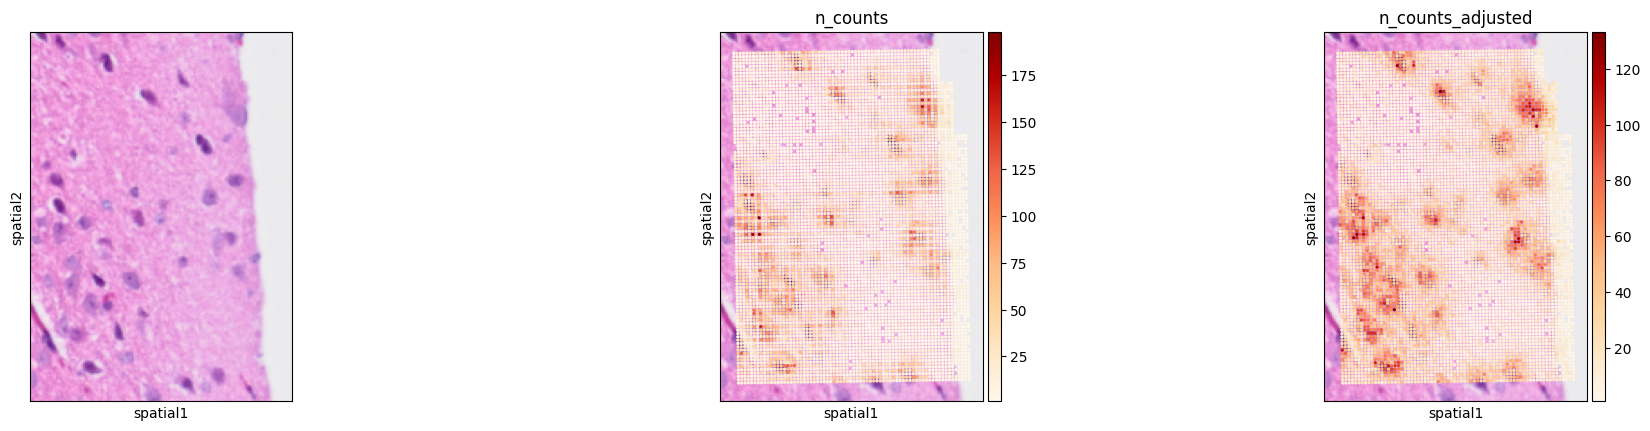

In [8]:
sc.pl.spatial(bdata, color=[None, "n_counts", "n_counts_adjusted"], color_map="OrRd")

We will begin by performing H&E segmentation with StarDist's H&E model. This is likely to be the main segmentation used in analysis due to consistently picking out nuclei, getting reliable information on the location of cells in the data. It is recommended to lower the `prob_thresh`, making the model more lenient with regard to what it calls as nuclei - the default setting is quite stringent, while we want to seed a good number of putative cells in the object.

We discuss other important segmentation parameters [here](https://bin2cell.readthedocs.io/en/latest/segmentation.html). Aside from the model stringency, the most important factor is the image resolution, as controlled via `mpp` earlier.

The segmentation results are turned to a sparse matrix and efficiently stored in an `.npz` file. If desired, they can be read via `scipy.sparse.load_npz()`, and the sparse matrix's dimensions will match those of the input image.

However, it is important to ensure that the gene expression bin grid is well aligned with the H&E image, or the mismatch will have bins loading segmentation results for sections of the tissue they are quite distant from. Visualising the total expression across parts of the tissue, similar to the plot made to show the "striped" effect earlier, is likely to be helpful in assessing the situation. In the event of a misalignment, the alignment can be [corrected via 10X's loupe browser](https://www.10xgenomics.com/support/software/space-ranger/latest/analysis/inputs/visium-hd-loupe-alignment).

In [9]:
b2c.stardist(image_path="stardist/he.tiff", 
             labels_npz_path="stardist/he.npz", 
             stardist_model="2D_versatile_he", 
             prob_thresh=0.01
            )

2024-11-12 21:58:43.750546: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 21:58:43.755537: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 21:58:43.769079: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-12 21:58:43.790697: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-12 21:58:43.790734: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 21:58:43.807231: I tensorflow/core/platform/cpu_feature_guard.cc:

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
effective: block_size=(4096, 4096, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


100%|██████████| 12/12 [03:43<00:00, 18.62s/it]


Found 61984 objects


We can now load the resulting cell calls into the object. For any given bin, its corresponding pixel in the segmented image will be located and any potential label transferred over. It's important to inform `b2c.insert_labels()` of whether the segmented image was based on array (GEX visualisation of the grid) or spatial (rescaled H&E image) coordinates, which exact spatial representation matches the image, and what `mpp` was used.

In [10]:
b2c.insert_labels(adata, 
                  labels_npz_path="stardist/he.npz", 
                  basis="spatial", 
                  spatial_key="spatial_cropped_150_buffer",
                  mpp=mpp, 
                  labels_key="labels_he"
                 )

Let's visualise the nuclear H&E segmentation on our selected region. The nuclei are identified successfully.

3610035367.py (5): Trying to modify attribute `.obs` of view, initializing view as actual.


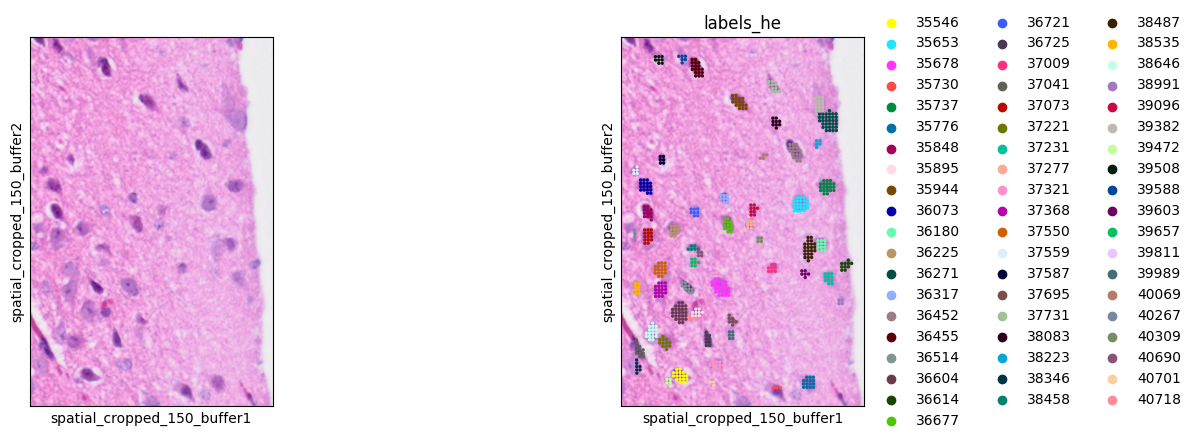

In [11]:
bdata = adata[mask]

#the labels obs are integers, 0 means unassigned
bdata = bdata[bdata.obs['labels_he']>0]
bdata.obs['labels_he'] = bdata.obs['labels_he'].astype(str)

sc.pl.spatial(bdata, color=[None, "labels_he"], img_key="0.5_mpp_150_buffer", basis="spatial_cropped_150_buffer")

The package comes with a utility function to visualise the segmentation on the input image (or a crop of it, as shown below). As we can see, the calls are faithfully captured in the bins.

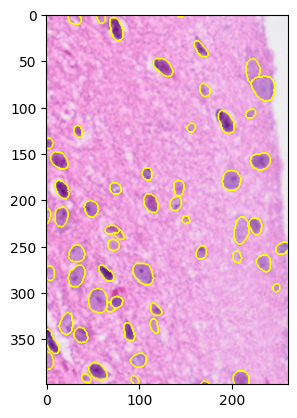

In [12]:
#the label viewer wants a crop of the processed image
#get the corresponding coordinates spanning the subset object
crop = b2c.get_crop(bdata, basis="spatial", spatial_key="spatial_cropped_150_buffer", mpp=mpp)

rendered = b2c.view_labels(image_path="stardist/he.tiff", 
                           labels_npz_path="stardist/he.npz", 
                           crop=crop
                          )
plt.imshow(rendered)

However, StarDist's H&E segmentation merely identifies nuclei, while there's more to a cell than just the nucleus. `b2c.expand_labels()` finds bins up to `max_bin_distance` (by default 2) bins away from a labelled nucleus, and joins them into the corresponding cell. Alternately, passing `algorithm="volume_ratio"` has each label get a custom expansion distance derived from its bin count, based on the linear relationship between cell and nuclear volume, controlled by `volume_ratio` with a [default of 4](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8893647/). In the event of a bin being equidistant from multiple nuclei, it's assigned to one based on the similarity of their gene expression profiles, as represented in PCA space.

In [13]:
b2c.expand_labels(adata, 
                  labels_key='labels_he', 
                  expanded_labels_key="labels_he_expanded"
                 )

The expanded labels capture more bins.

1371630977.py (5): Trying to modify attribute `.obs` of view, initializing view as actual.


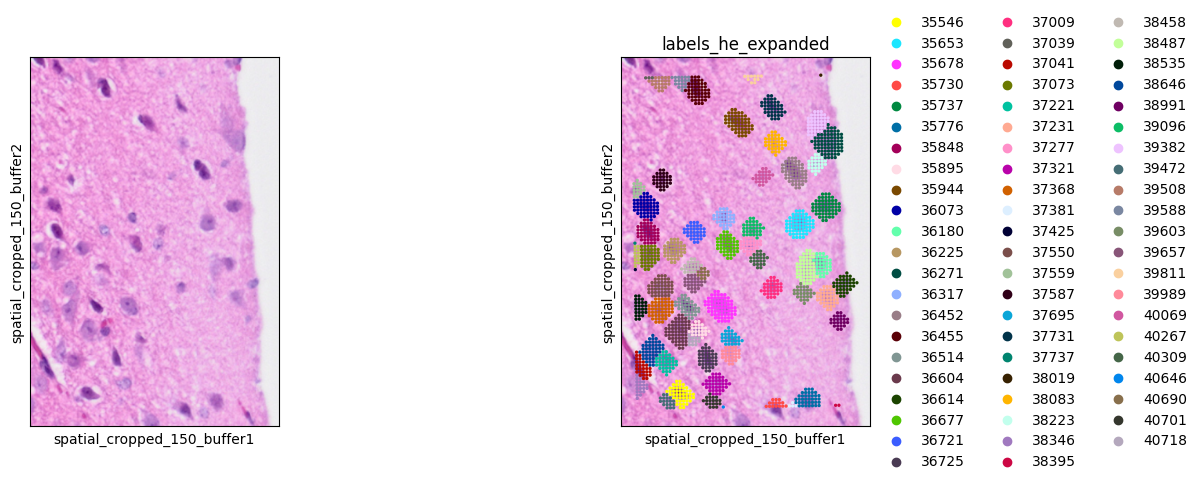

In [14]:
bdata = adata[mask]

#the labels obs are integers, 0 means unassigned
bdata = bdata[bdata.obs['labels_he_expanded']>0]
bdata.obs['labels_he_expanded'] = bdata.obs['labels_he_expanded'].astype(str)

sc.pl.spatial(bdata, color=[None, "labels_he_expanded"], img_key="0.5_mpp_150_buffer", basis="spatial_cropped_150_buffer")

The H&E segmentation is not guaranteed to be perfect. There may be some regions that have expression data but lack a visible nuclei to seed a cell. Alternately, nuclei may take on unusual shapes and not be detected by the model. Performing segmentation on a representation of total expression per bin may be able to detect some of the missed cells. However, this kind of segmentation only performs well on sparse tissue, and struggles to differentiate individual cells in dense regions. As such, we use it as secondary means of object identification, preferring H&E where able.

The input image is going to be a representation of the total counts per bin, with a Gaussian filter with a sigma of 5 (measured in pixels) applied for a little smoothing.

In [15]:
b2c.grid_image(adata, "n_counts_adjusted", mpp=mpp, sigma=5, save_path="stardist/gex.tiff")

The segmentation is performed via StarDist's fluorescence model, and identifies cells rather than nuclei, meaning subsequent label expasion is not necessary. Just like with the H&E model, lowering `prob_thresh` to make the calls less stringent is recommended. Increasing `nms_thresh` requires more of the putative objects to be overlapping for them to be merged into a single label, which may help a bit in denser regions.

In [16]:
b2c.stardist(image_path="stardist/gex.tiff", 
             labels_npz_path="stardist/gex.npz", 
             stardist_model="2D_versatile_fluo", 
             prob_thresh=0.05, 
             nms_thresh=0.5
            )

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
effective: block_size=(4096, 4096), min_overlap=(128, 128), context=(128, 128)


100%|██████████| 16/16 [08:05<00:00, 30.36s/it]


Found 50576 objects


The resulting calls are loaded like the H&E ones were, except the input image was based on array rather than spatial coordinates.

In [17]:
b2c.insert_labels(adata, 
                  labels_npz_path="stardist/gex.npz", 
                  basis="array", 
                  mpp=mpp, 
                  labels_key="labels_gex"
                 )

We can visualise the cells identified in the GEX space segmentation in our previously defined region.

1941188598.py (5): Trying to modify attribute `.obs` of view, initializing view as actual.


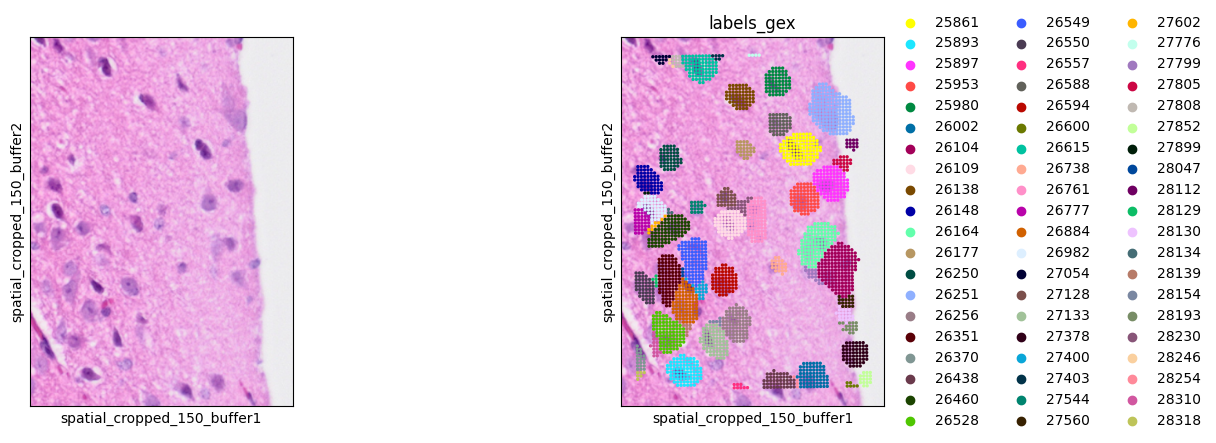

In [18]:
bdata = adata[mask]

#the labels obs are integers, 0 means unassigned
bdata = bdata[bdata.obs['labels_gex']>0]
bdata.obs['labels_gex'] = bdata.obs['labels_gex'].astype(str)

sc.pl.spatial(bdata, color=[None, "labels_gex"], img_key="0.5_mpp_150_buffer", basis="spatial_cropped_150_buffer")

The segmentation results can be viewed as well.

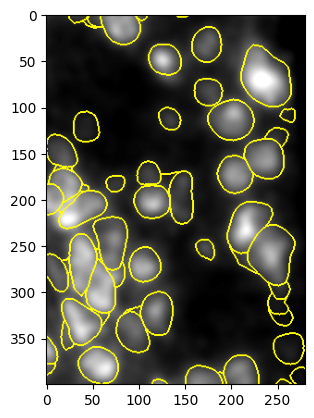

In [19]:
#the label viewer wants a crop of the processed image
#get the corresponding coordinates spanning the subset object
crop = b2c.get_crop(bdata, basis="array", mpp=mpp)

#GEX pops better with percentile normalisation performed
rendered = b2c.view_labels(image_path="stardist/gex.tiff", 
                           labels_npz_path="stardist/gex.npz", 
                           crop=crop,
                           stardist_normalize=True
                          )
plt.imshow(rendered)

Armed with both the H&E and gene expression segmentation results, we can now fill in the gaps in the H&E with GEX calls. We only add GEX cells that do not overlap with any H&E labels.

In [20]:
b2c.salvage_secondary_labels(adata, 
                             primary_label="labels_he_expanded", 
                             secondary_label="labels_gex", 
                             labels_key="labels_joint"
                            )

Salvaged 8060 secondary labels


A few extra GEX-derived cells show up in our test region. Note the presence of `.obs["labels_joint_source"]` which specifies whether any given label came from the primary or secondary labelling.

186021875.py (5): Trying to modify attribute `.obs` of view, initializing view as actual.


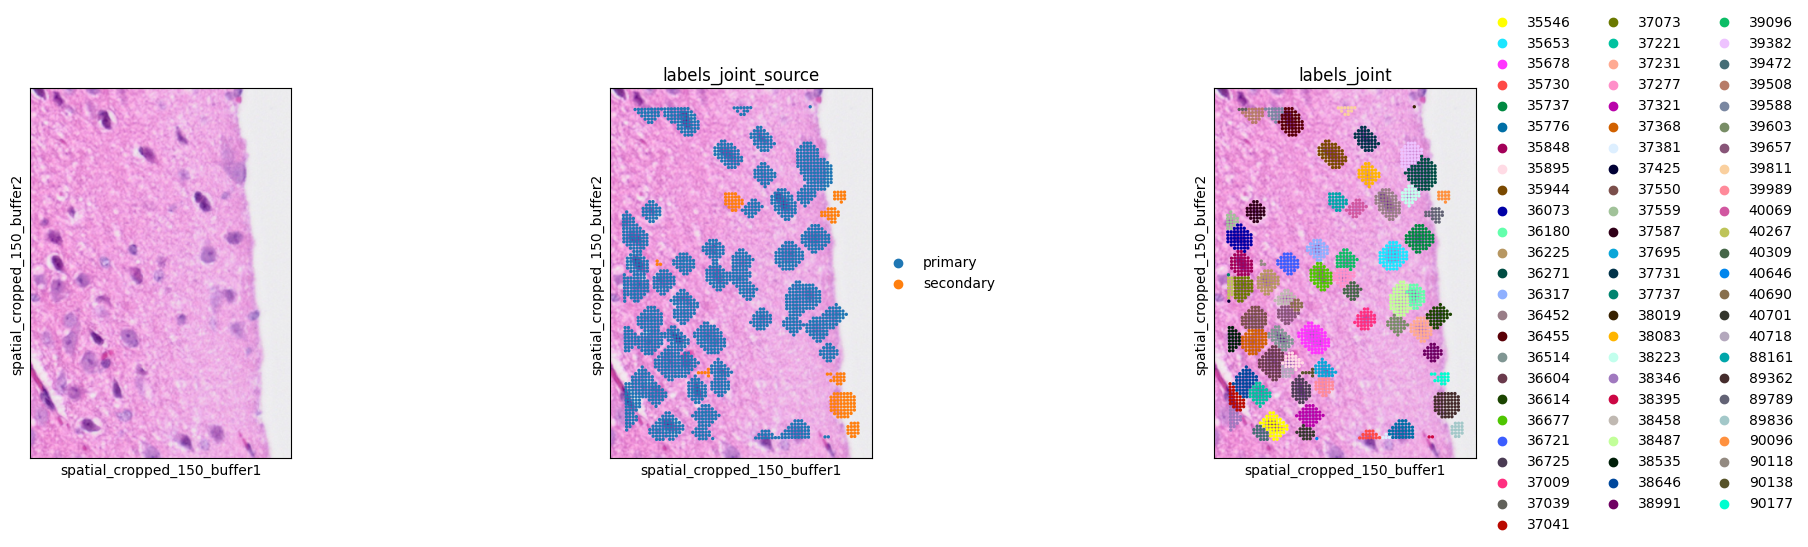

In [21]:
bdata = adata[mask]

#the labels obs are integers, 0 means unassigned
bdata = bdata[bdata.obs['labels_joint']>0]
bdata.obs['labels_joint'] = bdata.obs['labels_joint'].astype(str)

sc.pl.spatial(bdata, color=[None, "labels_joint_source", "labels_joint"], 
              img_key="0.5_mpp_150_buffer", basis="spatial_cropped_150_buffer")

At this point, the counts have been destriped and bins have been assigned to cells based on both H&E and GEX segmentation. Time to group the bins into cells!

In [22]:
cdata = b2c.bin_to_cell(adata, labels_key="labels_joint", spatial_keys=["spatial", "spatial_cropped_150_buffer"])

The object features the sum of gene expression of the constituent bins, and means of the array and spatial coordinates to represent the cell centroids. `.obs["labels_joint_source"]` is taken as well, providing information on which segmentation any given cell stems from. Let's visualise our test fragment of the tissue, now in cell space!

anndata.py (1209): Trying to modify attribute `.obs` of view, initializing view as actual.
anndata.py (1209): Trying to modify attribute `.var` of view, initializing view as actual.
anndata.py (1209): Trying to modify attribute `.var` of view, initializing view as actual.


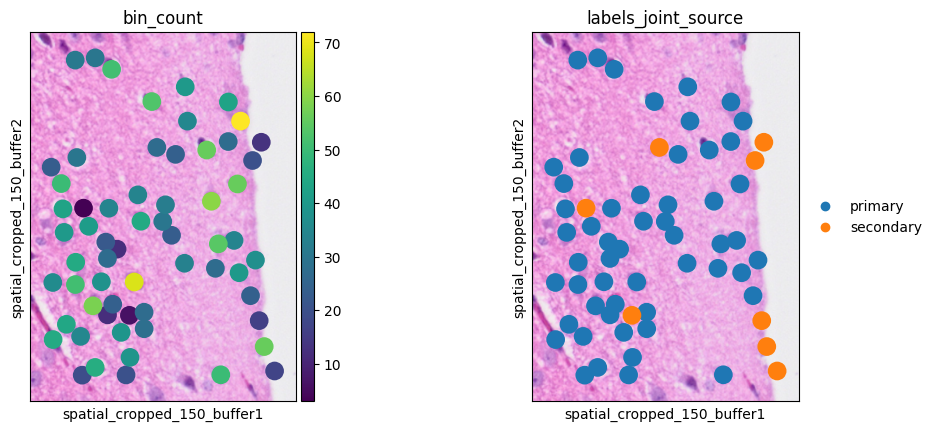

In [23]:
cell_mask = ((cdata.obs['array_row'] >= 1450) & 
             (cdata.obs['array_row'] <= 1550) & 
             (cdata.obs['array_col'] >= 250) & 
             (cdata.obs['array_col'] <= 450)
            )

ddata = cdata[cell_mask]
sc.pl.spatial(ddata, color=["bin_count", "labels_joint_source"], 
              img_key="0.5_mpp_150_buffer", basis="spatial_cropped_150_buffer")

At this point the object is ready for further analysis. As destriping provides non-integer values, if integers are strictly necessary for a downstream application just round the count matrix.